<a href="https://colab.research.google.com/github/truher/frc-test/blob/main/cv1/Radiance_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
"""Setup"""

import numpy as np
import sys
from google.colab import drive

drive.mount("/content/gdrive")
np.set_printoptions(
    edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x)
)
# the code in this notebook is formatted with Black https://black.vercel.app/ using 3.7, which is what this says:
print(sys.version)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [69]:
""" A simple photon simulator.

This is cribbed from https://github.com/DCC-Lab/PyTissueOptics.
"""

import copy
import numpy as np
from typing import List

class Vector:
    def __init__(self, x: float = 0, y: float = 0, z: float = 0):
        self._x = x
        self._y = y
        self._z = z

    def anyPerpendicular(self):
        if self._z < self._x:
            return Vector(self._y, -self._x, 0)
        return Vector(0, -self._z, self._y)

    def normalize(self):
        ux = self._x
        uy = self._y
        uz = self._z

        norm = ux * ux + uy * uy + uz * uz
        if norm != 0:
            invLength = norm ** (-0.5)
            self._x *= invLength
            self._y *= invLength
            self._z *= invLength
        else:
            raise ValueError("You cannot normalize the null vector")

        return self

    def rotateAround(self, u, theta):
        u.normalize()

        cost = np.cos(theta)
        sint = np.sin(theta)
        one_cost = 1 - cost

        ux = u._x
        uy = u._y
        uz = u._z

        X = self._x
        Y = self._y
        Z = self._z

        self._x = (
            (cost + ux * ux * one_cost) * X
            + (ux * uy * one_cost - uz * sint) * Y
            + (ux * uz * one_cost + uy * sint) * Z
        )
        self._y = (
            (uy * ux * one_cost + uz * sint) * X
            + (cost + uy * uy * one_cost) * Y
            + (uy * uz * one_cost - ux * sint) * Z
        )
        self._z = (
            (uz * ux * one_cost - uy * sint) * X
            + (uz * uy * one_cost + ux * sint) * Y
            + (cost + uz * uz * one_cost) * Z
        )
        return self

    def __str__(self):
        return f"Vector: x={self._x:.4f} y={self._y:.4f} z={self._z:.4f})"

class UnitVector(Vector):
    def __init__(self, x, y, z):
        Vector.__init__(self, x, y, z) 

    @staticmethod
    def spherical(theta, phi):
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        return UnitVector(x,y,z)

    @staticmethod
    def cartesian(x, y, z):
        v = Vector(x,y,z).normalize()
        return UnitVector(v._x, v._y, v._z)

    def phi(self) -> float:
        """ Returns [-pi, pi]."""
        return np.arctan2(self._y, self._x)

    def theta(self) -> float:
        return np.arccos(self._z)

class Photon:
    def __init__(self, R, EZ):
        self.r = R # local coordinate position
        self.ez = EZ # propagation direction
        self.er = self.ez.anyPerpendicular() # perpendicular to direction, used for rotation

    @staticmethod
    def spherical(x, y, z, theta, phi):
        # local coordinate position
        r = Vector(x, y, z)
        # propagation direction
        ez = UnitVector.spherical(theta, phi)
        return Photon(r, ez)

    def scatterBy(self, theta, phi) -> None:
        """Mutates this photon."""
        self.er.rotateAround(self.ez, phi)
        self.ez.rotateAround(self.er, theta)

    def __str__(self):
        return f"Photon: x={self.r._x:.2f} y={self.r._y:.2f} z={self.r._z:.2f} theta={self.ez.theta():.2f} phi={self.ez.phi():.2f}"


class Source:
    def newPhoton(self) -> Photon:
        raise NotImplementedError()


class PencilSource(Source):
    """Zero area zero divergence."""

    def newPhoton(self) -> Photon:
        return Photon.spherical(0, 0, 0, 0, 0)


class HalfSphereSource(Source):
    """Isotropic intensity in the upper half-sphere."""

    def __init__(self, width, height):
        self._width = width
        self._height = height

    def newPhoton(self) -> Photon:
        x = self._width * (np.random.random() - 0.5)
        y = self._height * (np.random.random() - 0.5)
        phi = np.random.random() * 2 * np.pi
        theta = np.arccos(np.random.random())
        p = Photon.spherical(x, y, 0, 0, 0)
        p.scatterBy(theta, phi)
        return p

    def __str__(self):
        return f"HalfSphereSource: width={self._width:.2f} height={self._height:.2f}"


class LambertianSource(Source):
    def __init__(self, width, height):
        self._width = width
        self._height = height

    def newPhoton(self) -> Photon:
        x = self._width * (np.random.random() - 0.5)
        y = self._height * (np.random.random() - 0.5)
        phi = np.random.random() * 2 * np.pi
        theta = np.arccos(2 * np.random.random() - 1) / 2
        p = Photon.spherical(x, y, 0, theta, phi)
        return p


class RealLEDSource(Source):
    """TODO: use the published data from Cree."""

    def __init__(self, width, height):
        self._width = width  # microns
        self._height = height  # microns

    def newPhoton(self) -> Photon:
        x = self._width * (np.random.random() - 0.5)
        y = self._height * (np.random.random() - 0.5)
        phi = np.random.random() * 2 * np.pi
        theta = np.arccos(2 * np.random.random() - 1) / 2
        p = Photon.spherical(x, y, 0, theta, phi)
        return p


class Diffuser:
    """ Something that changes photon direction.

    Examples: diffuser, retroreflector.
    """
    def __init__(self, g):
        self._g = g
    
    # this is from material.py.
    def getScatteringAngles(self):
        """Henyey and Greenstein.  g is their parameter: 0 is iso, 1 is no scattering, -1 is reflection."""
        phi = np.random.random() * 2 * np.pi
        temp = (1 - self._g * self._g) / (1 - self._g + 2 * self._g * np.random.random())
        cost = (1 + self._g * self._g - temp * temp) / (2 * self._g)
        return np.arccos(cost), phi
    
    def diffuse(self, photons: List[Photon]) -> List[Photon]:
        """Adjust propagation direction.

            g: Henyey/Greenstein parameter.
        """
        diffusedPhotons = []
        for p in photons:
            p = copy.deepcopy(p)
            # TODO use the actual diffuser angular distribution here
            theta_scatter, phi_scatter = self.getScatteringAngles()
            p.scatterBy(theta_scatter, phi_scatter)
            diffusedPhotons.append(p)

        return diffusedPhotons


class Lightbox:
    """ Represents the box between the source and diffuser.

    Sides are somewhat reflective.
    """
    def __init__(self, height, size):
        """
        height: top of the box above the source
        size: full length or width, box is square.
        """
        self._height = height
        self._size = size

    def propagate(self, photons: List[Photon]) -> List[Photon]:
        """ Propagate photons through the light box to the top."""
        survivingPhotons = []
        # count reflections:
        xnct = 0
        xpct = 0
        ynct = 0
        ypct = 0

        absorption = 0.1 # polished metal inside
        for p in photons:
            # photon starts at p.r(x,y).  assume p.r(z) is zero (TODO fix that)
            if p.ez._z < 0:
                continue # this shouldn't happen
            # find the new x and y:
            dpx = p.r._x + self._height * p.ez._x / p.ez._z
            dpy = p.r._y + self._height * p.ez._y / p.ez._z
            d_ez_z = p.ez._z # reflections don't change z
            d_ez_x = p.ez._x
            d_ez_y = p.ez._y
 
            done_reflecting = False
            while not done_reflecting:
                if dpx < -self._size/2:
                    dpx = -self._size - dpx
                    d_ez_x *= -1
                    if np.random.random() < absorption:
                        xnct += 1
                        break
                elif dpx > self._size/2:
                    dpx = self._size - dpx
                    d_ez_x *= -1
                    if np.random.random() < absorption:
                        xpct += 1
                        break
                elif dpy < -self._size/2:
                    dpy = -self._size - dpy
                    d_ez_y *= -1                
                    if np.random.random() < absorption:
                        ynct += 1
                        break
                elif dpy > self._size/2:
                    dpy = self._size - dpy
                    d_ez_y *= -1                
                    if np.random.random() < absorption:
                        ypct += 1
                        break
                if dpx >= -self._size / 2 and dpx <= self._size / 2 and dpy >= -self._size / 2 and dpy <= self._size / 2:
                    done_reflecting = True
            if done_reflecting: # i.e. not early break
                r = Vector(dpx, dpy, self._height)
                ez = UnitVector.cartesian(d_ez_x, d_ez_y, d_ez_z)
                p = Photon(r, ez)
                survivingPhotons.append(p)
                
        print(f"xnct {xnct} xpct {xpct} ynct {ynct} ypct {ypct}")
        return survivingPhotons

def propagateToReflector(photons: List[Photon], location, size) -> List[Photon]:
    """ just push them up there.
      location: z dimension of the reflector.  it's *far*, if the unit is 100 microns,
      and the reflector is 1-10 meters away, that's 10000-100000.
      size: say 10cm on a side, 1000 units.
    there's no box.
    todo: make this a class, combine it somehow with the other one above
    """
    survivingPhotons = []
    for p in photons:
        if p.ez._z < 0:
            continue
        distance_z = location - p.r._z
        dpx = p.r._x + distance_z * p.ez._x / p.ez._z
        dpy = p.r._y + distance_z * p.ez._y / p.ez._z
        if dpx < -size / 2 or dpx > size / 2 or dpy < -size / 2 or dpy > size / 2:
            continue
        d_ez_z = p.ez._z
        d_ez_x = p.ez._x
        d_ez_y = p.ez._y

        r = Vector(dpx, dpy, location)
        ez = UnitVector.cartesian(d_ez_x, d_ez_y, d_ez_z)
        p = Photon(r, ez)
        survivingPhotons.append(p)
                
    return survivingPhotons

def propagateToCamera(photons: List[Photon], location) -> List[Photon]:
    """ back down to the camera.
   
    for now it's just the camera plane. TODO: add a counter.
    """
    survivingPhotons = []
    for p in photons:
        distance_z = location - p.r._z # negative number in this case
        dpx = p.r._x + distance_z * p.ez._x / p.ez._z
        dpy = p.r._y + distance_z * p.ez._y / p.ez._z
        d_ez_z = p.ez._z
        d_ez_x = p.ez._x
        d_ez_y = p.ez._y
        r = Vector(dpx, dpy, location)
        ez = UnitVector.cartesian(d_ez_x, d_ez_y, d_ez_z)
        p = Photon(r, ez)
        survivingPhotons.append(p)
    return survivingPhotons    



In [89]:
""" Plotting functions"""

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
from matplotlib.patches import Circle, Rectangle
from mpl_toolkits.mplot3d import Axes3D

def plot_rays(batches, elev, azim, size, arrow_length, sample, rectangles) -> None:
    """3d plot a set of photon batches, each batch a different color.

    Also render interesting rectangles.  [xmin,xmax,ymin,ymax,z]
    """
    fig = plt.figure(figsize=[15, 15])
    ax = fig.gca(projection="3d")
    for i, p_batch in enumerate(batches):
        output_len = int(len(p_batch)/sample) + 1
        photonX = np.zeros([output_len])
        photonY = np.zeros([output_len])
        photonZ = np.zeros([output_len])
        photonU = np.zeros([output_len])
        photonV = np.zeros([output_len])
        photonW = np.zeros([output_len])
        for pidx, p in enumerate(p_batch):
            if pidx % sample != 0:
                continue
            sample_idx = int(pidx / sample)
            photonX[sample_idx] = p.r._x
            photonY[sample_idx] = p.r._y
            photonZ[sample_idx] = p.r._z
            photonU[sample_idx] = arrow_length * p.ez._x
            photonV[sample_idx] = arrow_length * p.ez._y
            photonW[sample_idx] = arrow_length * p.ez._z
        ax.quiver(
            photonX,
            photonY,
            photonZ,
            photonU,
            photonV,
            photonW,
            arrow_length_ratio=0.05,
            color=f"C{i%10}",
        )
    ax.set_xlim([-size / 2, size / 2])
    ax.set_ylim([-size / 2, size / 2])
    ax.set_zlim([0, size])
    ax.view_init(elev, azim)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    for ri, r in enumerate(rectangles):
        xmin = r[0]
        xmax = r[1]
        ymin = r[2]
        ymax = r[3]
        z = r[4]
        p = Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, linewidth=5, color=f'C{ri%10}')
        ax.add_patch(p)
        art3d.pathpatch_2d_to_3d(p, z=z, zdir="z")
    plt.show()


def plot_histogram_slices(photon_batch, x_min, x_max, y_min, y_max,
                          theta_min = 0, theta_max = np.pi,
                          phi_min = -np.pi, phi_max = np.pi,
                          bins = 100):
    """Slice counts by x, y, phi, and theta, also show intensity per steradian."""
    # TODO: radiance is *projected* area, so compute that too
    # radiosity (W/m^2): all directions, per area (slice in x, total in y)
    x_freq = np.zeros(bins, dtype=int)
    # radiosity (W/m^2): all directions, per area (slice in y, total in x)
    y_freq = np.zeros(bins, dtype=int)
    # radiant intensity (W/sr): whole area, per angle (slice in theta, total in phi)
    theta_freq = np.zeros(bins, dtype=int)
    # radiant intensity (W/sr): whole area, per angle (slice in phi, total in theta)
    phi_freq = np.zeros(bins, dtype=int)
    photons_per_steridian_by_theta = np.zeros(bins, dtype=float)

    x_range = x_max - x_min
    x_bin_width = x_range / bins
    x_bins = x_range * np.arange(bins) / bins + x_min # TODO units

    y_range = y_max - y_min
    y_bin_width = y_range / bins
    y_bins = y_range * np.arange(bins) / bins + y_min # TODO units

    theta_range = theta_max - theta_min
    theta_bin_width_rad = theta_range / bins
    theta_bin_width_deg = theta_bin_width_rad * 180 / np.pi

    theta_bins_rad = (theta_range * np.arange(bins) / bins + theta_min)
    theta_bins_deg = theta_bins_rad * 180 / np.pi
#    theta_bins = np.array(list(map(lambda x: (theta_range * (x + 0.5) + theta_min) / bins, range(bins))))

    phi_range = phi_max - phi_min
    phi_bin_width_rad = phi_range / bins
    phi_bin_width_deg = phi_bin_width_rad * 180 / np.pi
    phi_bins_deg = (phi_range * np.arange(bins) / bins + phi_min) * 180 / np.pi
 #   phi_bins = (phi_range * np.arange(bins) / bins + phi_min)

#    phi_bins = np.array(list(map(lambda x: (phi_range * (x + 0.5) + phi_min) / bins, range(bins))))

    for p in photon_batch:
        # "floor" so that it doesn't double-count near zero.
        # TODO: figure out the area thing here
        x_bin = int((p.r._x - x_min) // x_bin_width)
        if x_bin < 0 or x_bin > bins - 1:
            continue
        x_freq[x_bin] += 1
        y_bin = int((p.r._y - y_min) // y_bin_width)
        if y_bin < 0 or y_bin > bins - 1:
            continue
        y_freq[y_bin] += 1
        theta_bin = int((p.ez.theta() - theta_min) // theta_bin_width_rad)
        if theta_bin < 0 or theta_bin > bins - 1:
            continue        
        theta_freq[theta_bin] += 1
        phi_bin = int((p.ez.phi() - phi_min) // phi_bin_width_rad)
        if phi_bin < 0 or phi_bin > bins - 1:
            continue
        phi_freq[phi_bin] += 1
        # TODO: figure out the area thing here
        photons_per_steridian_by_theta[theta_bin] += 1 / np.sin(p.ez.theta())

    # the above histograms are counts per bucket.
    # i want counts per steradian.
    # it's axially symmetric so ignore phi
    # the size of a theta bucket is
    #  h = np.cos(left) - np.cos(right)
    #  area = 2 * np.pi * h
    # the bin width is np.pi / 100

    thetaBucketAngleSteradians = np.array(
        list(
            map(
                lambda x: (np.cos((theta_range * x + theta_min) / bins) 
                - np.cos((theta_range * (x + 1) + theta_min) / bins)),
                range(bins),
            )
        )
    )
    photonsPerSteradianByTheta = theta_freq / thetaBucketAngleSteradians

    f = plt.figure(figsize=(18, 10))

    ax = plt.subplot(231)
    plt.bar(x=x_bins, height=x_freq, width=x_bin_width)
    ax.set_title("photons per bucket by x")
    ax.set_xlabel("x dimension (TODO: unit)")
    ax.set_ylabel("photon count per bucket (TODO: density)")

    ax = plt.subplot(232)
    plt.bar(x=y_bins, height=y_freq, width=y_bin_width)
    ax.set_title("photons per bucket by y")
    ax.set_xlabel("y dimension (TODO: unit)")
    ax.set_ylabel("photon count per bucket (TODO: density)")

    ax = plt.subplot(233)
    plt.bar(x=phi_bins_deg, height=phi_freq, width=phi_bin_width_deg)
    ax.set_title("photons per bucket by phi")
    ax.set_xlabel("azimuth (phi) (degrees)")
    ax.set_ylabel("photon count per bucket (TODO: density)")

    ax = plt.subplot(234)
    plt.bar(x=theta_bins_deg, height=theta_freq, width=theta_bin_width_deg)
    ax.set_title("photons per bucket by theta")
    ax.set_xlabel("polar angle (theta) (degrees)")
    ax.set_ylabel("photon count per bucket (TODO: density)")

    ax = plt.subplot(235)
    plt.bar(x=theta_bins_deg, height=photonsPerSteradianByTheta, width=theta_bin_width_deg)
    ax.set_title("radiant intensity photons/sr by theta by bucket area")
    ax.set_xlabel("polar angle (theta) (degrees)")
    ax.set_ylabel("photon count per ... ? (TODO: sr)")
    # notice the higher variance at the poles; N is lower there, which is not good.

    ax = plt.subplot(236)
    plt.bar(x=theta_bins_deg, height=photons_per_steridian_by_theta, width=theta_bin_width_deg)
    ax.set_title("radiant intensity photons/sr by photon weights")
    ax.set_xlabel("polar angle (theta) (degrees)")
    ax.set_ylabel("photon count per ... ? (TODO: sr)")

    plt.show()

    f = plt.figure(figsize=[15, 12])
    ax = plt.subplot(projection="polar")
    ax.set_theta_zero_location("N")
    # mirror the data so it looks nice .. resulting in the weird bounds here
    ax.set_thetamin(-theta_max * 180 / np.pi)
    ax.set_thetamax(theta_max * 180 / np.pi)
    ax.bar(
        theta_bins_rad, photons_per_steridian_by_theta, width=theta_bin_width_rad, color="black"
    )
    ax.bar(
        -theta_bins_rad, photons_per_steridian_by_theta, width=theta_bin_width_rad, color="black"
    )
    ax.set_xlabel("polar angle (theta) (degrees)")
    ax.set_ylabel("photon count per ... ? (TODO: sr)")


"Relative Luminous Intensity" from the [Cree XP-E2 datasheet](https://cree-led.com/media/documents/XLampXPE2.pdf)

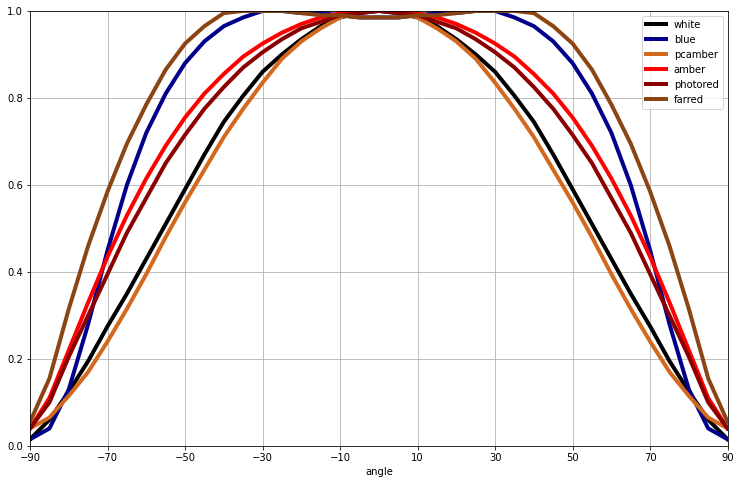

In [48]:
""" Show Cree XP-E2 data."""
import pandas as pd


def get_cree_data():
    # spatial-distribution.txt data is eyeballed from https://cree-led.com/media/documents/XLampXPE2.pdf, page 20.
    df = pd.read_csv(
        "/content/gdrive/MyDrive/spatial-distribution.txt", delim_whitespace=True
    )
    return df

def mirror(df):
    """ Mirror the data on the negative side of the angle scale, for visualization."""
    # The angle is the polar angle, so it is never negative, but it's common to visualize
    # on a [-90,90] scale.
    df2 = df.copy()
    df2["angle"] = df2["angle"] * -1
    df3 = pd.concat([df, df2])
    df3 = df3.sort_values(by=["angle"])
    return df3

def show_cree_data(df3):
    """ Duplicates the charts on page 20."""
    ax = df3.plot(
        x="angle",
        color=["black", "darkblue", "chocolate", "red", "darkred", "saddlebrown"],
        xlim=[-90, 90],
        ylim=[0, 1],
        grid=True,
        figsize=[12.5, 8],
        linewidth=4,
        xticks=[-90, -70, -50, -30, -10, 10, 30, 50, 70, 90],
    )


cree_spatial_distribution = get_cree_data()
cree_spatial_distribution_both_sides = mirror(cree_spatial_distribution)
show_cree_data(cree_spatial_distribution_both_sides)

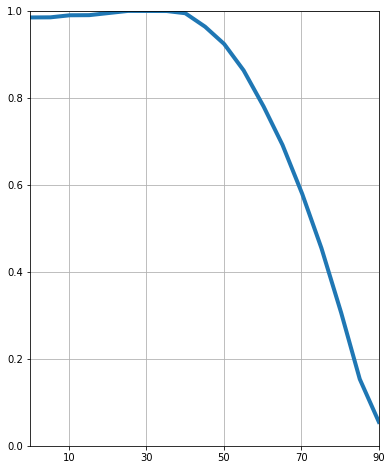

In [49]:
""" Show interpolated spatial distribution.

To use the Cree data above, I need a continuous version of it; try interp1d.
"""
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate


def make_interpolated_spatial_distribution(cree_data):
    farred = interpolate.interp1d(cree_data["angle"], cree_data["farred"])
    x_new = np.arange(0, 90, 0.001)
    y_new = farred(x_new)
    return pd.DataFrame({"angle": x_new, "farred": y_new})


def show_interpolated_spatial_distribution(df_interp):
    plt.figure(figsize=[6.25, 8])
    ax = plt.subplot()
    plt.plot(df_interp["angle"], df_interp["farred"], "-", linewidth=4)
    ax.grid(True)
    ax.set_xlim(0, 90)
    ax.set_ylim(0, 1)
    ax.set_xticks([10, 30, 50, 70, 90])


cree_spatial_distribution_interpolated = make_interpolated_spatial_distribution(
    cree_spatial_distribution
)
show_interpolated_spatial_distribution(cree_spatial_distribution_interpolated)



Polar coordinates.  "Photo Red" is the most nearly Lambertian.

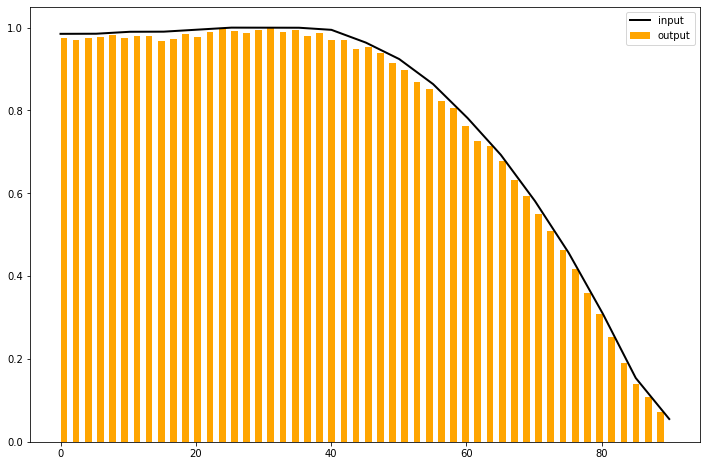

In [50]:
""" Show how to generate random numbers matching a given distribution.

Cribbed from https://stackoverflow.com/questions/17821458/random-number-from-histogram
"""

def generate_rand_from_pdf(pdf: pd.Series, x_grid: pd.Series) -> pd.Series:
    cdf = pdf.cumsum()
    cdf = cdf / cdf.iloc[-1]
    values = np.random.rand(1000000)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf

def show_histogram_fit():
    given_x: pd.Series = cree_spatial_distribution_interpolated['angle']
    given_pdf: pd.Series = cree_spatial_distribution_interpolated['farred']
    random_from_cdf: pd.Series = generate_rand_from_pdf(given_pdf, given_x)

    f = plt.figure(figsize=[12,8])
    plt.plot(given_x, given_pdf, '-', linewidth=2, label='input', color='black')
    counts, bins = np.histogram(random_from_cdf, 50)
    plt.hist(bins[:-1], bins, weights=counts/counts.max(), color='orange', label='output', width=1)
    plt.legend();

show_histogram_fit()

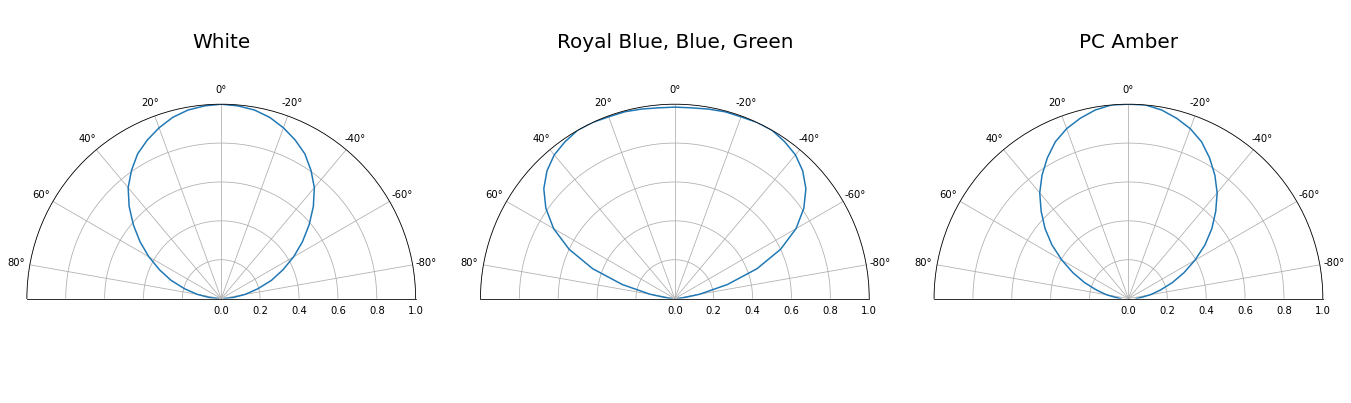

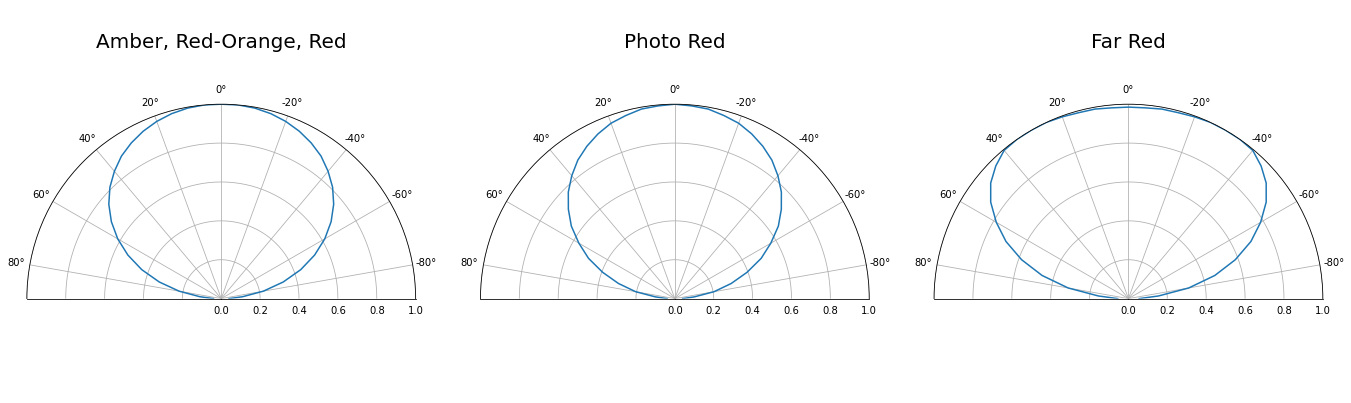

In [51]:
""" Show spatial distribution in polar coordinates."""
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.transforms import Bbox


def show_cree_data_polar(df3):
    df4 = df3.copy()
    df4["radians"] = df4["angle"] * np.pi / 180
    # there are two figures here because I couldn't figure out how to make the half-polar plots
    # the right size in a grid.
    titles = ["White", "Royal Blue, Blue, Green", "PC Amber"]
    columns = ["white", "blue", "pcamber"]
    positions = [131, 132, 133]
    subpositions = [
        [0.0, -0.6, 0.3, 1.4],
        [0.35, -0.6, 0.65, 1.4],
        [0.7, -0.6, 1.0, 1.4],
    ]
    f = plt.figure(figsize=[18, 3])
    for t, c, p, s in zip(titles, columns, positions, subpositions):
        ax = plt.subplot(p, polar=True)
        ax.set_theta_zero_location("N")
        ax.set_thetamin(-90)
        ax.set_thetamax(90)
        ax.set_title(t, pad=-60, fontsize=20)
        bb = Bbox.from_extents(s)
        ax.set_position(bb)
        plt.polar(df4["radians"], df4[c])
        ax.set_rmax(1.0)

    titles = ["Amber, Red-Orange, Red", "Photo Red", "Far Red"]
    columns = ["amber", "photored", "farred"]

    f = plt.figure(figsize=[18, 3])
    for t, c, p, s in zip(titles, columns, positions, subpositions):
        ax = plt.subplot(p, polar=True)
        ax.set_theta_zero_location("N")
        ax.set_thetamin(-90)
        ax.set_thetamax(90)
        ax.set_title(t, pad=-60, fontsize=20)
        bb = Bbox.from_extents(s)
        ax.set_position(bb)
        plt.polar(df4["radians"], df4[c])
        ax.set_rmax(1.0)


show_cree_data_polar(cree_spatial_distribution_both_sides)


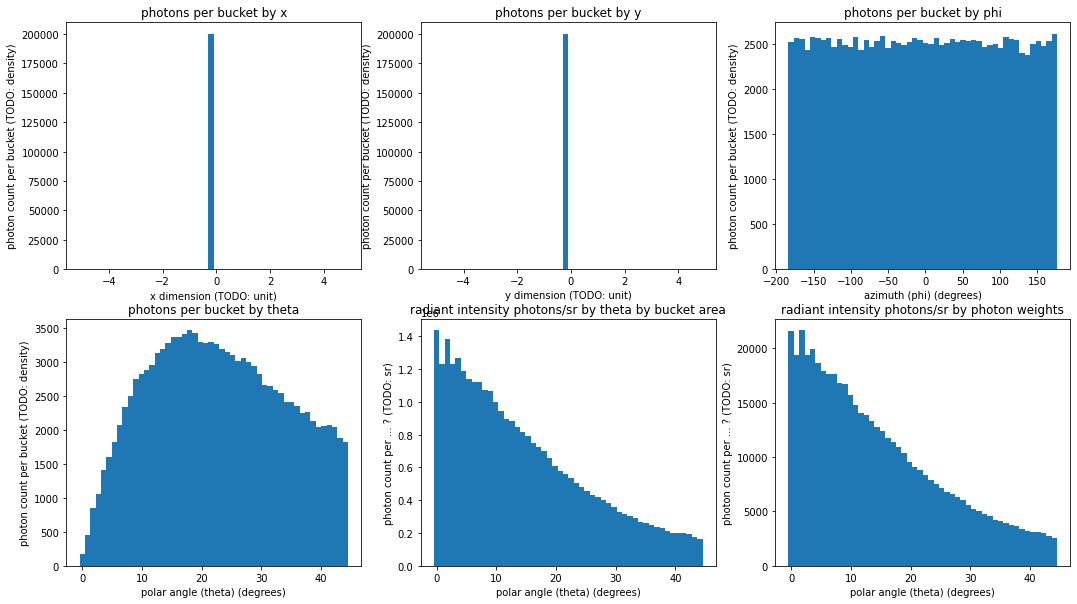

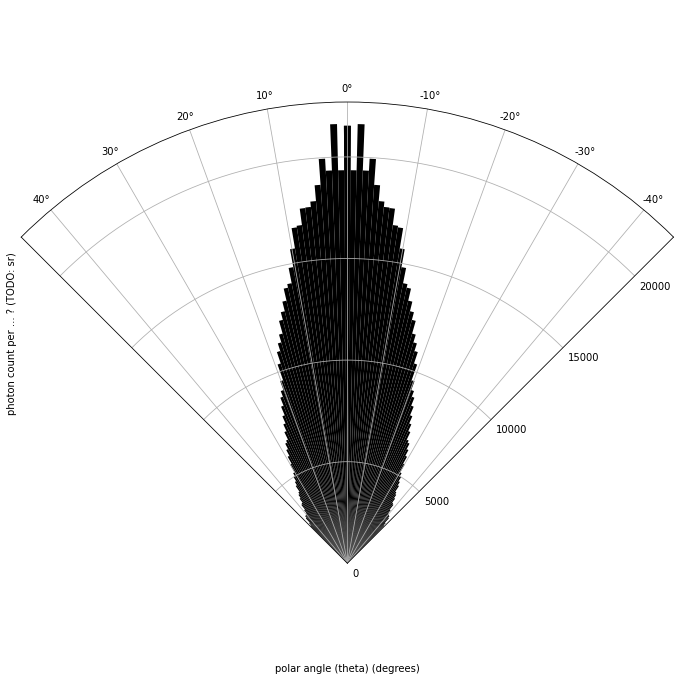

In [52]:
""" Show the intensity plot for the diffuser.

The plan is to use Acrylite 0D010DF in the 0.118 thickness, available at Tap plastics.
It is described here:
https://www.acrylite.co/files/content/acrylite.co/documents/product-information/satinice/ACRYLITE-Satinice-Enhanced-Acrylic.pdf
as producing 40-degree FWHM scattering. 
"""
def verify_diffuser():
  pencil_source = PencilSource()
  photons = []
  for pi in range(200000): # pretty high resolution
    p = pencil_source.newPhoton()
    photons.append(p)

  diffuser = Diffuser(g = 0.64)
  diffusedPhotons = diffuser.diffuse(photons)
  plot_histogram_slices(diffusedPhotons, x_min=-5, x_max=5, y_min=-5, y_max=5, theta_min=0, theta_max=np.pi/4, bins=50)

verify_diffuser()


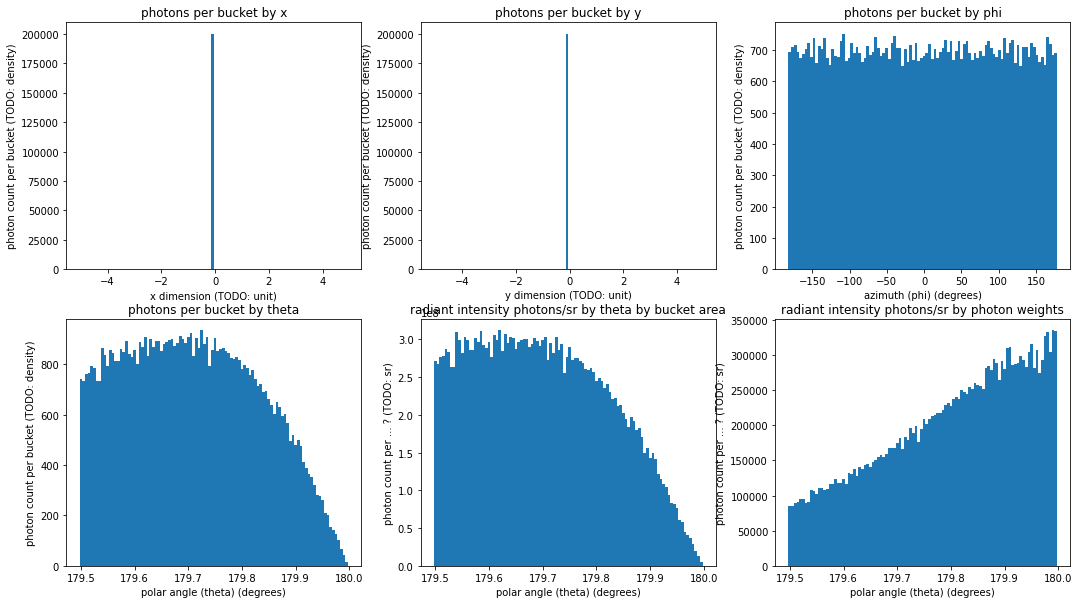

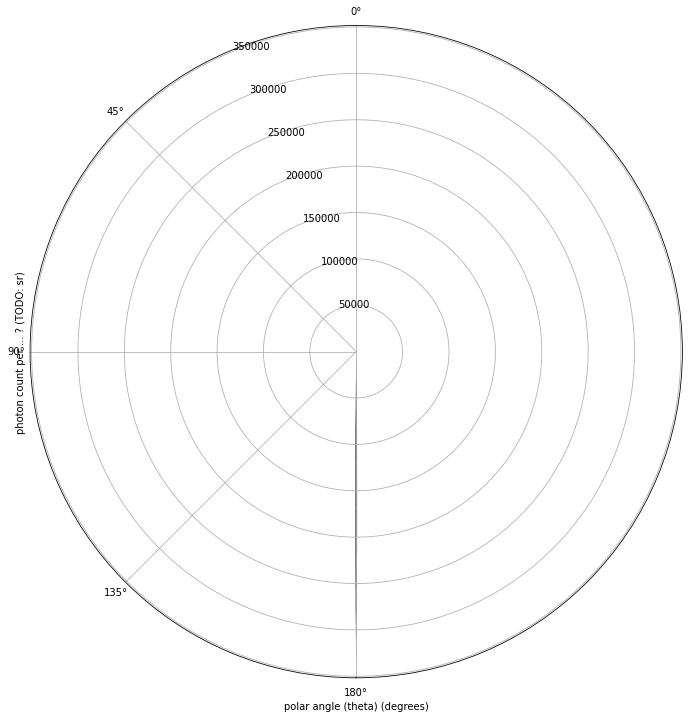

In [53]:
""" Show the intensity plot for the reflector.

FRC uses 3M Scotchlite, which has a reflection coefficient, R_A, of 500 at 0.2 degrees.
"""
def verify_reflector():
  pencil_source = PencilSource()
  photons = []
  for pi in range(200000): # pretty high resolution
    p = pencil_source.newPhoton()
    photons.append(p)

  reflector = Diffuser(g = -0.9925)
  diffusedPhotons = reflector.diffuse(photons)

  plot_histogram_slices(diffusedPhotons, x_min=-5, x_max=5, y_min=-5, y_max=5, theta_min=179.5*np.pi/180, theta_max=np.pi, bins=100)

verify_reflector()




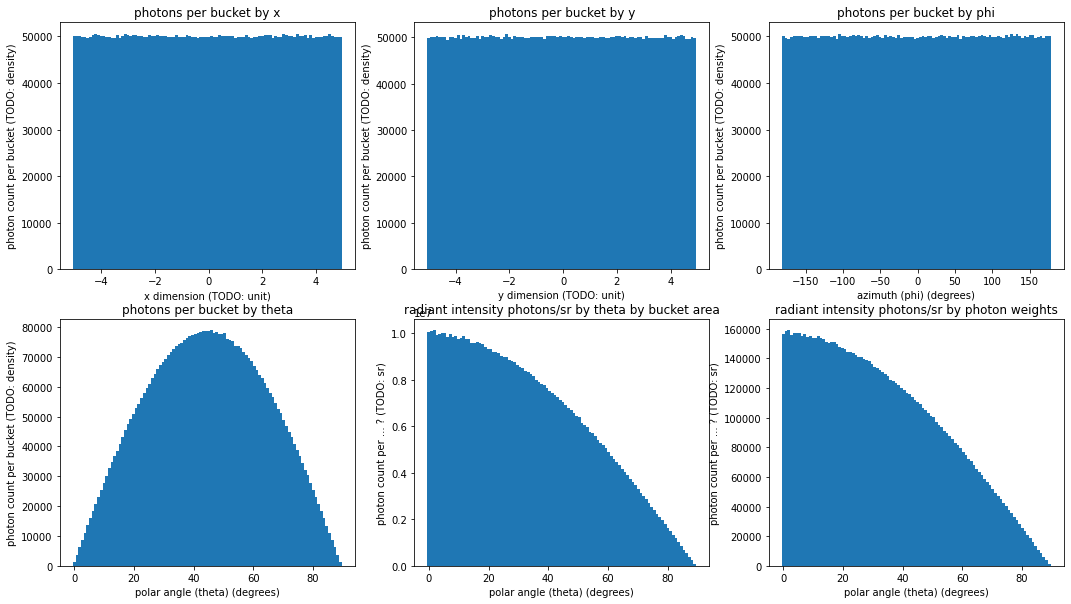

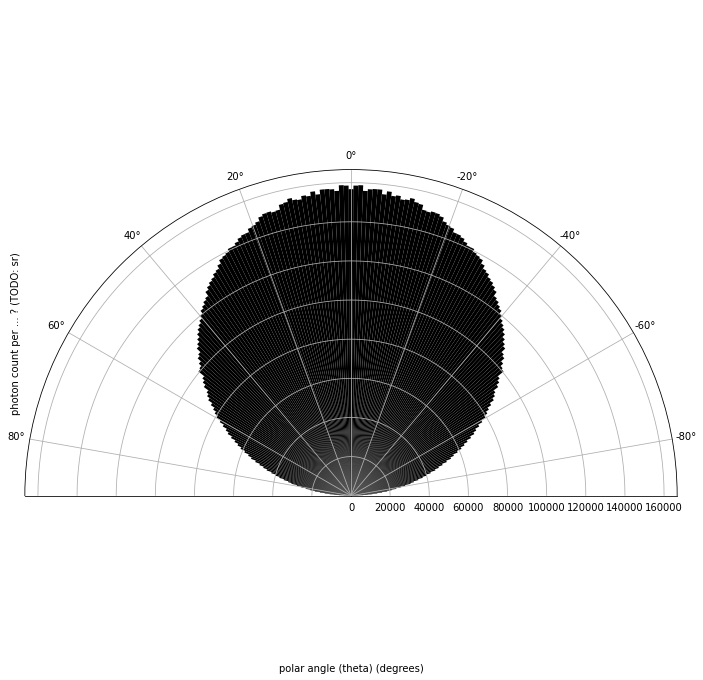

In [103]:
""" Generate some photons and show their distribution."""
import matplotlib.pyplot as plt


def make_photons():
    photon_count = 5000000
    # say the units are like 100 microns?  so like 1mm square?
    # s = PencilSource()
    # s = HalfSphereSource(10, 10)
    # Lambertian is pretty close for now.
    # TODO: use the Cree distribution
    s = LambertianSource(10, 10)

    photons = []
    for pi in range(photon_count):
        p = s.newPhoton()
        photons.append(p)
    return photons


photons = make_photons()


In [ ]:
plot_histogram_slices(photons, -5, 5, -5, 5, theta_max = np.pi/2)

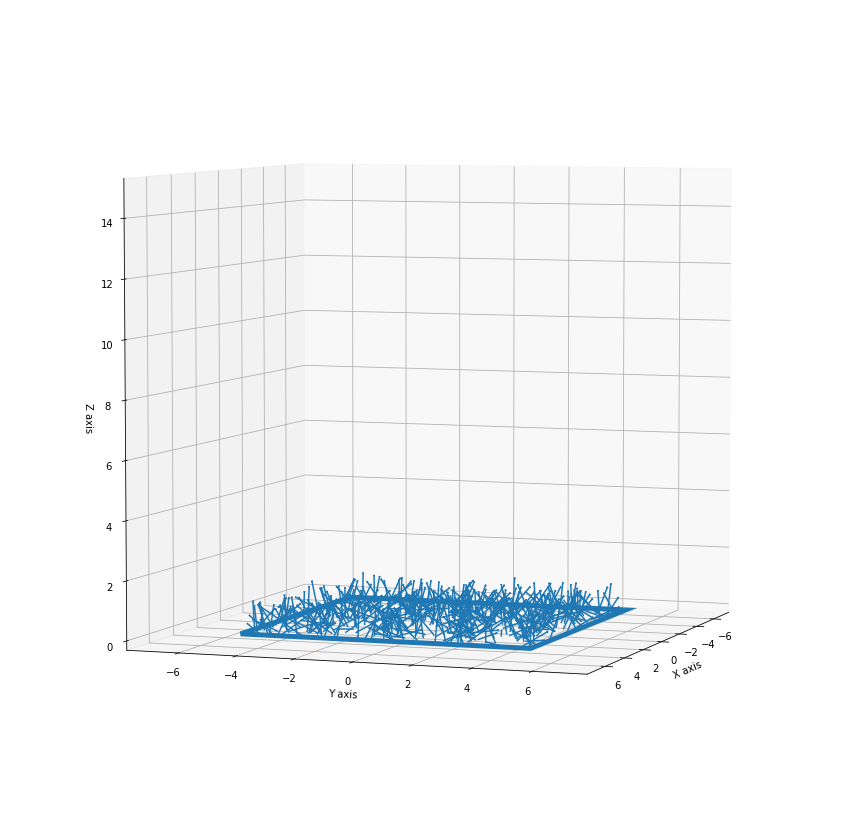

In [90]:
plot_rays([photons], 5, 20, 15, 1, sample=100, rectangles=[[ -5, 5, -5, 5, 0]])

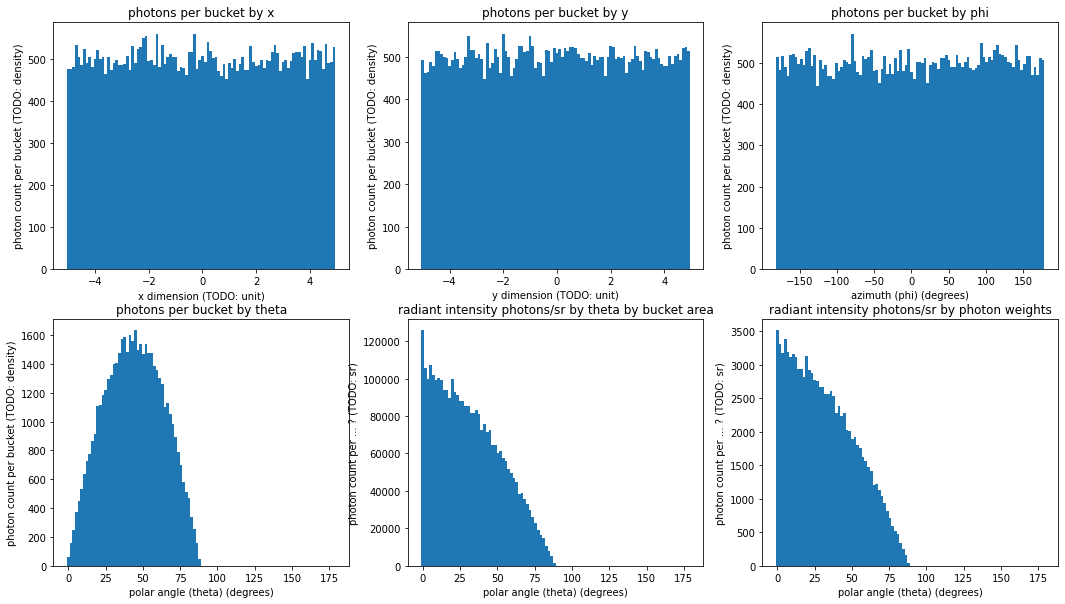

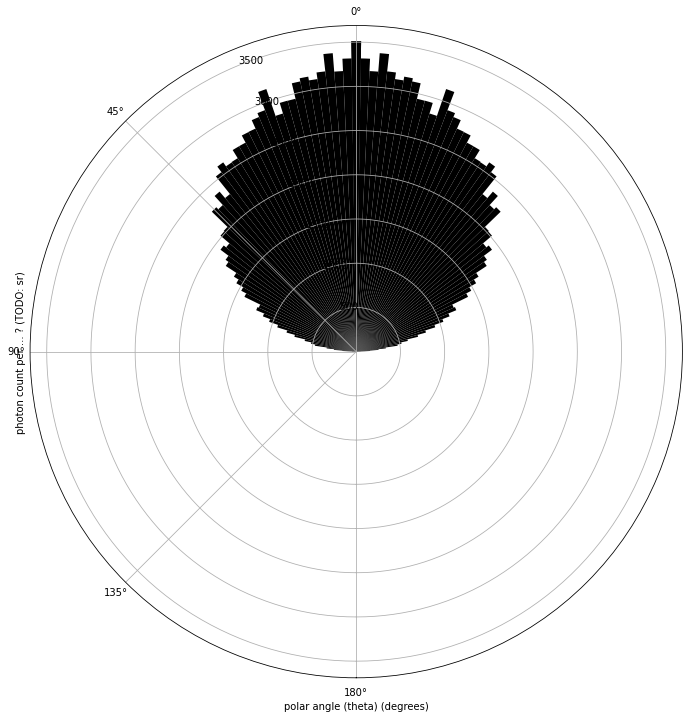

In [56]:
plot_histogram_slices(photons, -5, 5, -5, 5)

In [104]:
lightbox = Lightbox(height = 800, size = 800)
survivingPhotons = lightbox.propagate(photons)
print(f"original photons: {len(photons)}")
print(f"surviving photons: {len(survivingPhotons)}")

xnct 208563 xpct 208384 ynct 178855 ypct 178499
original photons: 5000000
surviving photons: 4225699


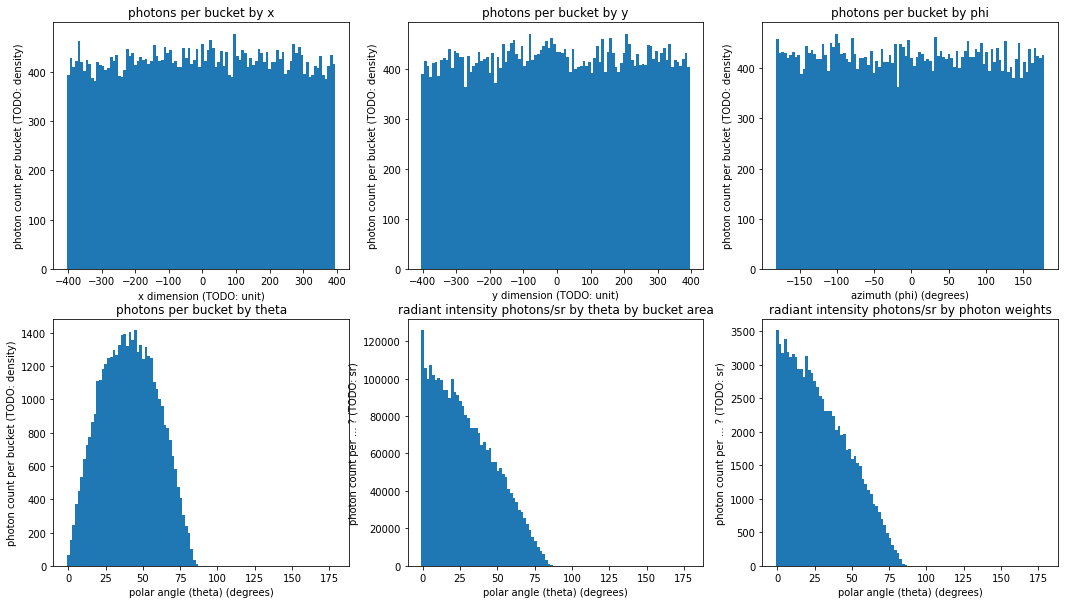

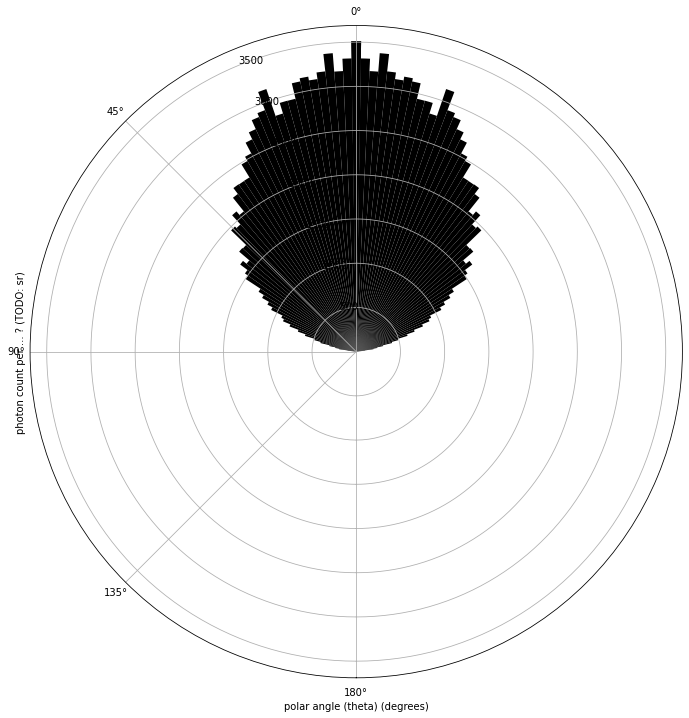

In [58]:
plot_histogram_slices(survivingPhotons, x_min=-400, x_max=400, y_min=-400, y_max=400)

In [ ]:
diffuser = Diffuser(g = 0.64)
diffusedPhotons = diffuser.diffuse(survivingPhotons)
print(f"surviving photons: {len(survivingPhotons)}")
print(f"diffused photons: {len(diffusedPhotons)}")

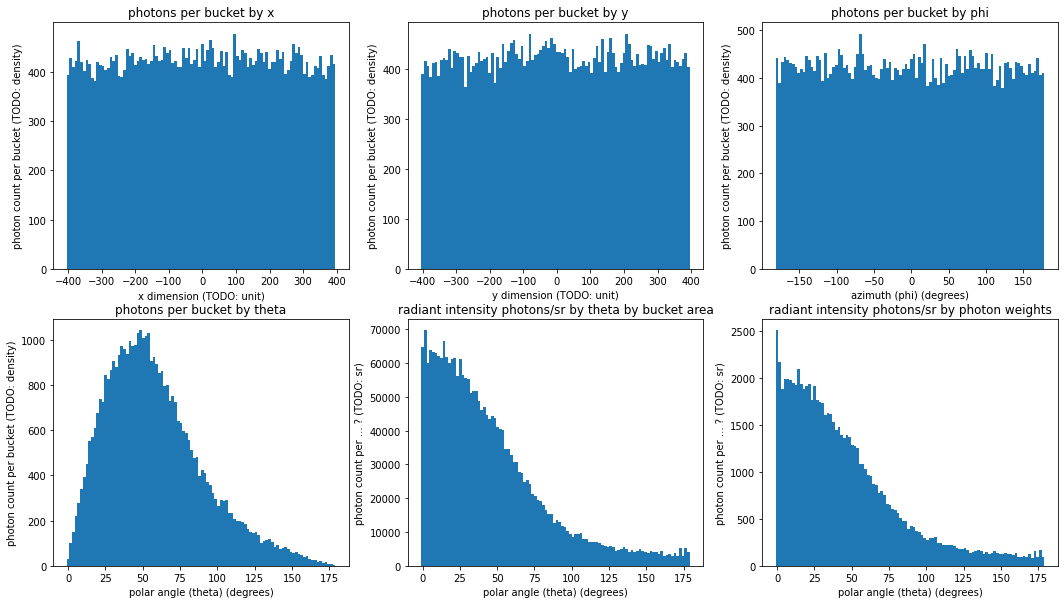

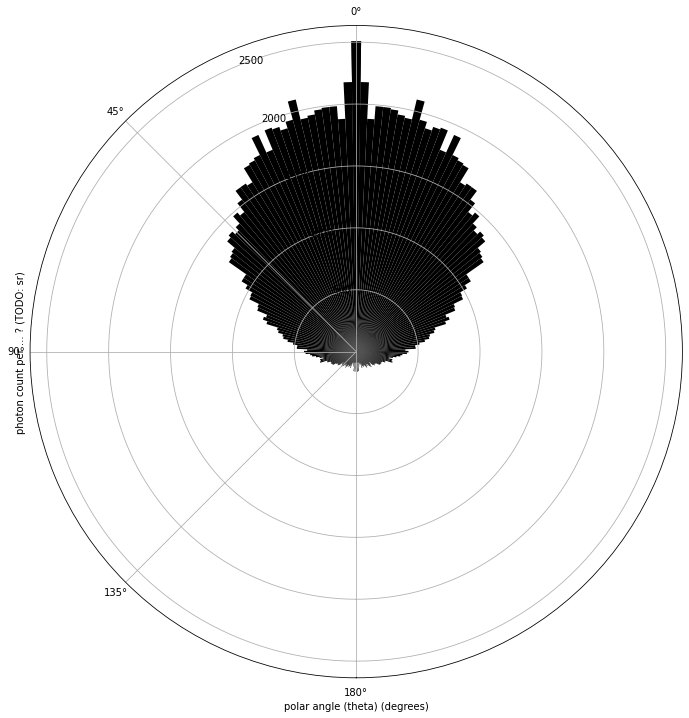

In [60]:
plot_histogram_slices(diffusedPhotons, x_min=-400, x_max=400, y_min=-400, y_max=400)

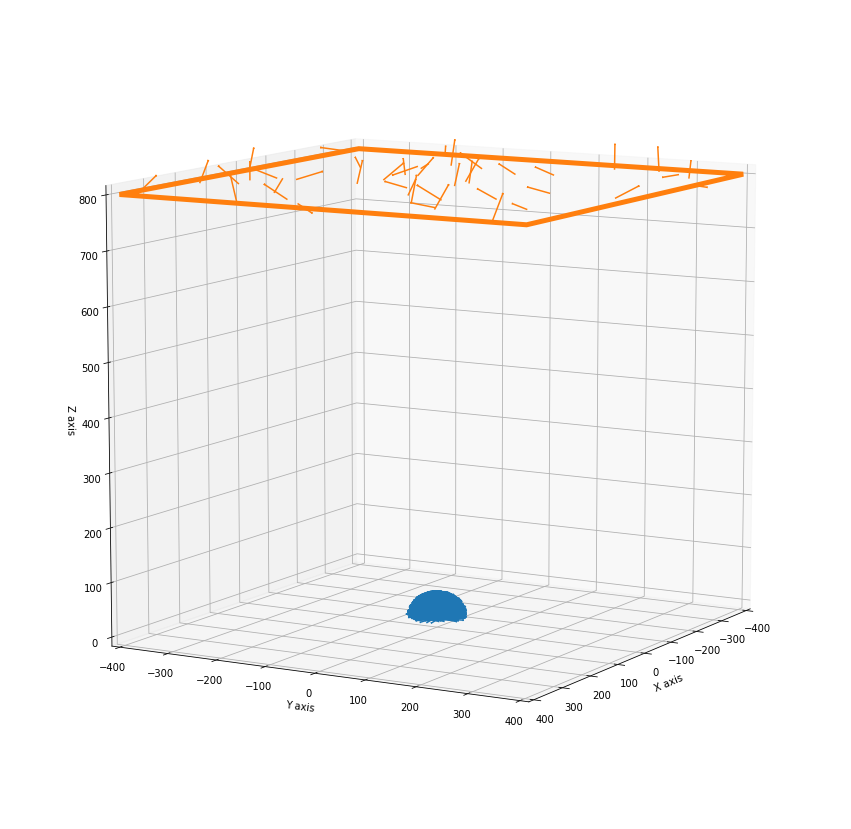

In [105]:
plot_rays([photons, diffusedPhotons], elev = 10, azim = 30, size = 800, arrow_length = 50, sample = 1000,
          rectangles=[[ -5, 5, -5, 5, 0],
                      [-400,400,-400,400,800]])

diffused photons: 42263
photons_at_reflector: 2


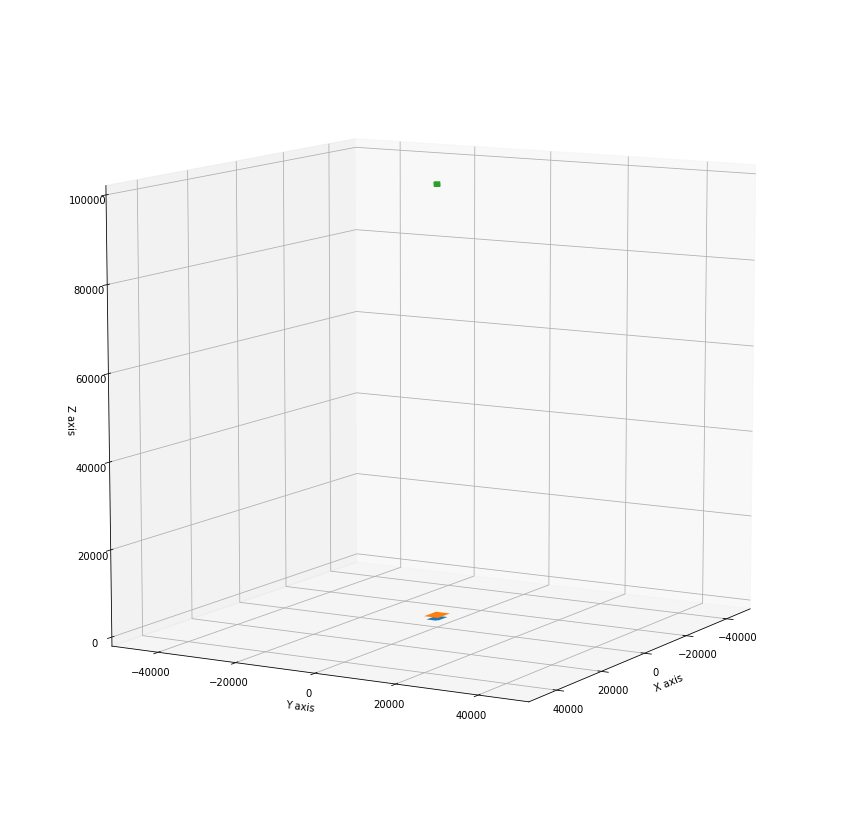

In [97]:
# set up a detector above the diffuser to make sure it works
# min distance might be ... 10000 = 1 meter?  maybe less?
# max distance is probably ~100000 = 10 meters
photons_at_reflector = propagateToReflector(diffusedPhotons, location = 100000, size = 1000)
print(f"diffused photons: {len(diffusedPhotons)}")
print(f"photons_at_reflector: {len(photons_at_reflector)}")

plot_rays([photons, diffusedPhotons, photons_at_reflector ], 
          elev = 10, azim = 30, size = 100000, arrow_length = 100, sample = 1,
          rectangles=[[ -5, 5, -5, 5, 0],
                      [-400, 400, -400, 400, 800],
                      [-500, 500, -500, 500, 100000]]
          )

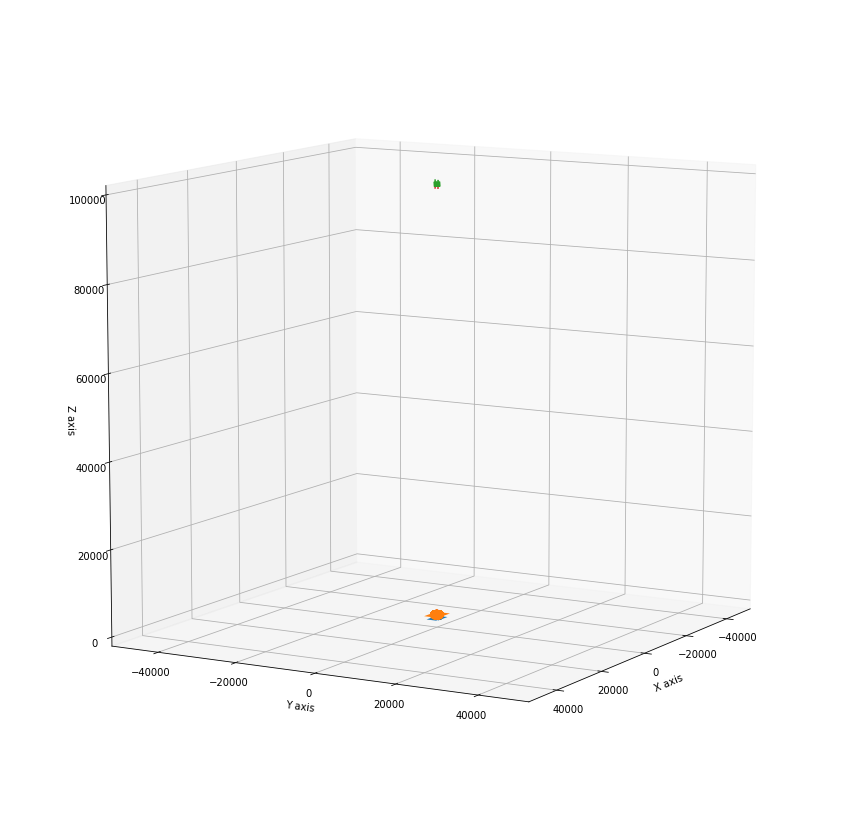

In [98]:
reflector = Diffuser(g = -0.9925)
reflected_photons = reflector.diffuse(photons_at_reflector)

plot_rays([photons, diffusedPhotons, photons_at_reflector, reflected_photons], 
          elev = 10, azim = 30, size = 100000, arrow_length = 1000, sample = 1,
          rectangles=[[ -5, 5, -5, 5, 0],
                      [-400, 400, -400, 400, 800],
                      [-500, 500, -500, 500, 100000]]
          )

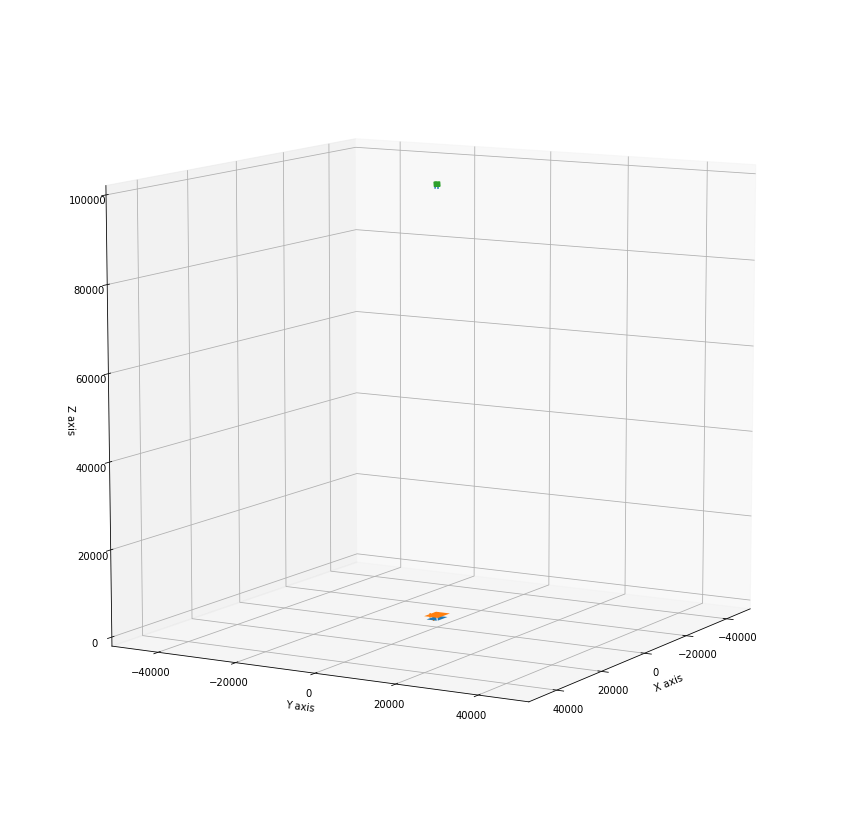

In [99]:
photons_at_camera_plane = propagateToCamera(reflected_photons, location = 800)
plot_rays([reflected_photons, photons_at_camera_plane], 
          elev = 10, azim = 30, size = 100000, arrow_length = 1000, sample = 1,
          rectangles=[[ -5, 5, -5, 5, 0],
                      [-400, 400, -400, 400, 800],
                      [-500, 500, -500, 500, 100000]]
          )

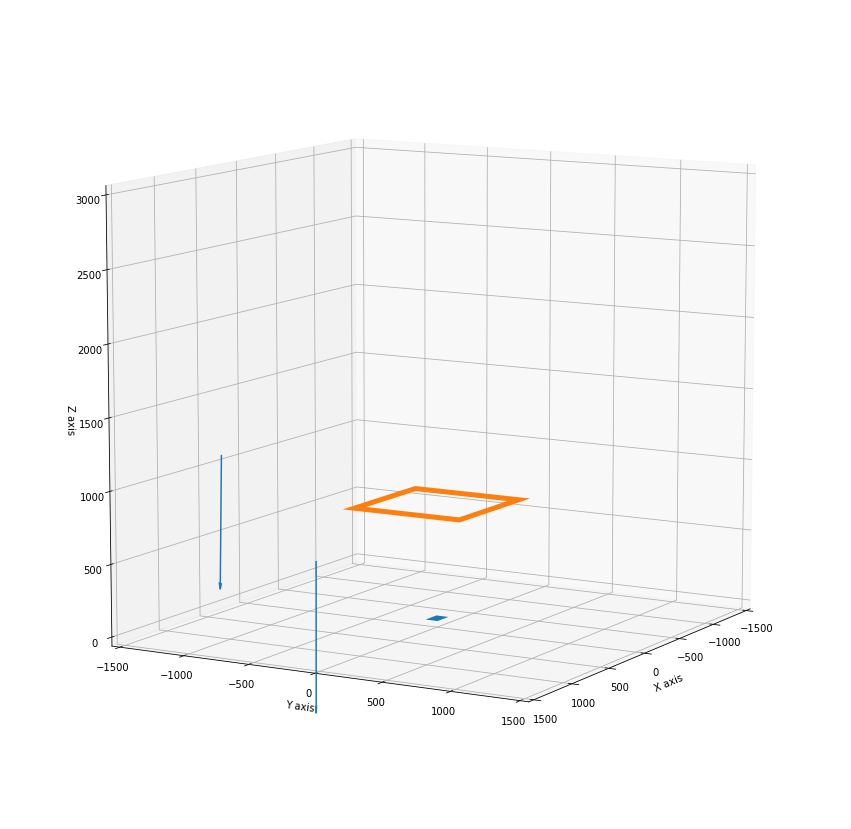

In [102]:
# look closer at the detector
plot_rays([photons_at_camera_plane], 
          elev = 10, azim = 30, size = 3000, arrow_length = 1000, sample = 1,
          rectangles=[[ -5, 5, -5, 5, 0],
                      [-400, 400, -400, 400, 800]]
          )